In diesem Notebook führen wir Web Scraping durch, um die aktuellen Temperaturen für österreichische Städte von der Webseite https://wetter.orf.at/oes/ auszulesen. Anschließend speichern wir die extrahierten Temperaturwerte in einem Array ab, um sie später mit Daten aus einer Datenbank zu vergleichen. Dieser Ansatz ermöglicht es, aktuelle Wetterdaten automatisiert zu erfassen und mit anderen Datenquellen zu verknüpfen.

In [18]:
import requests
from bs4 import BeautifulSoup

# --- Web Scraping ---

url = "https://wetter.orf.at/oes/"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

def get_temperature(city_name):
    # Suche den <h3> mit dem Städtenamen
    city_header = soup.find('h3', itemprop="name", string=city_name)
    if city_header:
        # Suche das nächste <p> mit der Klasse 'temperature' nach dem Header
        temp_tag = city_header.find_next('p', class_='temperature')
        if temp_tag:
            # Extrahiere den Temperaturwert (mit Komma als Dezimaltrennzeichen)
            temp_text = temp_tag.text.strip().split('°')[0].replace(',', '.')
            return float(temp_text)
    return None

cities = ["Wien", "Graz", "Linz", "Salzburg", "Innsbruck", "Klagenfurt", "Bregenz"]

temperatures = {city: get_temperature(city) for city in cities}

print(temperatures)

{'Wien': 23.7, 'Graz': 24.6, 'Linz': 24.9, 'Salzburg': 25.8, 'Innsbruck': 28.1, 'Klagenfurt': 26.2, 'Bregenz': 25.5}


In diesem Abschnitt rufen wir die in der Datenbank gespeicherten Wetterdaten der letzten drei Stunden ab, die aus einer API stammen. Wir berechnen den Durchschnitt für die Spalten humidity_pct und pressure_hpa jeweils für die Städte: Vienna, Linz, Graz, Salzburg, Innsbruck, Klagenfurt und Bregenz. Anschließend vergleichen wir diese Durchschnittswerte mit den aktuellen Temperaturen, die wir zuvor per Web Scraping ermittelt haben. So erhalten wir eine Übersicht über die aktuellen Wetterverhältnisse im Kontext der letzten Stunden.

In [19]:
import requests
from bs4 import BeautifulSoup
import psycopg2
from datetime import datetime, timedelta, timezone

# --- Verbindung zur PostgreSQL Datenbank aufbauen ---

conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="weather_db",
    user="bdeng",
    password="bdengpass"
)
cursor = conn.cursor()

# --- Durchschnittswerte der letzten 3 Stunden abfragen ---

# Liste der Städte, für die wir Werte berechnen
cities = ["Vienna", "Linz", "Graz", "Salzburg", "Innsbruck", "Klagenfurt", "Bregenz"]

# Berechne Zeitstempel für 3 Stunden zurück
now = datetime.now(tz=timezone.utc)
three_hours_ago = now - timedelta(hours=3)

# SQL Query - berechnet AVG(humidity_pct) und AVG(pressure_hpa) für jede Stadt
query = """
SELECT city_name,
       AVG(humidity_pct) AS avg_humidity,
       AVG(pressure_hpa) AS avg_pressure
FROM weather_data_api
WHERE city_name = ANY(%s)
  AND timestamp_utc >= %s
GROUP BY city_name;
"""

cursor.execute(query, (cities, three_hours_ago))
results = cursor.fetchall()

# Ergebnisse in ein Dictionary packen
avg_values = {row[0]: {'avg_humidity': row[1], 'avg_pressure': row[2]} for row in results}

print(avg_values)

# Verbindung schließen
cursor.close()
conn.close()

{'Klagenfurt': {'avg_humidity': Decimal('40.1028037383177570'), 'avg_pressure': 1023.0}, 'Salzburg': {'avg_humidity': Decimal('43.3644859813084112'), 'avg_pressure': 1022.9308411214953}, 'Bregenz': {'avg_humidity': Decimal('96.7607476635514019'), 'avg_pressure': 1020.0}, 'Linz': {'avg_humidity': Decimal('40.0747663551401869'), 'avg_pressure': 1023.0}, 'Graz': {'avg_humidity': Decimal('42.7233644859813084'), 'avg_pressure': 1023.9308411214953}, 'Innsbruck': {'avg_humidity': Decimal('46.4579439252336449'), 'avg_pressure': 1021.9308411214953}, 'Vienna': {'avg_humidity': Decimal('37.1757009345794393'), 'avg_pressure': 1023.9308411214953}}


Folgendes ist eine Auflistung der aktuellen Temperatur und der durchscnittlichen Luftfeuchtigkeit bzw. des durchscnittlichen Luftdrucks der letzten Stunden.

In [20]:
# --- Vergleich Ausgabe ---

print("\nDurchschnittswerte der letzten 3 Stunden aus DB:")
for city in cities:
    if city == 'Vienna': city = 'Wien'
    temp = temperatures.get(city)
    if city == 'Wien': city = 'Vienna'
    avg_humidity = avg_values.get(city, {}).get('avg_humidity')
    avg_pressure = avg_values.get(city, {}).get('avg_pressure')
    
    print(f"\nStadt: {city}")
    if temp is not None:
        print(f"  Aktuelle Temperatur: {temp} °C")
    else:
        print("  Aktuelle Temperatur: Nicht verfügbar (kein Scraping-Daten)")
    
    if avg_humidity is not None and avg_pressure is not None:
        print(f"  Durchschnitt Luftfeuchtigkeit: {avg_humidity:.2f} %")
        print(f"  Durchschnitt Luftdruck: {avg_pressure:.2f} hPa")
    else:
        print("  Durchschnittswerte aus DB: Nicht verfügbar")


Durchschnittswerte der letzten 3 Stunden aus DB:

Stadt: Vienna
  Aktuelle Temperatur: 23.7 °C
  Durchschnitt Luftfeuchtigkeit: 37.18 %
  Durchschnitt Luftdruck: 1023.93 hPa

Stadt: Linz
  Aktuelle Temperatur: 24.9 °C
  Durchschnitt Luftfeuchtigkeit: 40.07 %
  Durchschnitt Luftdruck: 1023.00 hPa

Stadt: Graz
  Aktuelle Temperatur: 24.6 °C
  Durchschnitt Luftfeuchtigkeit: 42.72 %
  Durchschnitt Luftdruck: 1023.93 hPa

Stadt: Salzburg
  Aktuelle Temperatur: 25.8 °C
  Durchschnitt Luftfeuchtigkeit: 43.36 %
  Durchschnitt Luftdruck: 1022.93 hPa

Stadt: Innsbruck
  Aktuelle Temperatur: 28.1 °C
  Durchschnitt Luftfeuchtigkeit: 46.46 %
  Durchschnitt Luftdruck: 1021.93 hPa

Stadt: Klagenfurt
  Aktuelle Temperatur: 26.2 °C
  Durchschnitt Luftfeuchtigkeit: 40.10 %
  Durchschnitt Luftdruck: 1023.00 hPa

Stadt: Bregenz
  Aktuelle Temperatur: 25.5 °C
  Durchschnitt Luftfeuchtigkeit: 96.76 %
  Durchschnitt Luftdruck: 1020.00 hPa


In diesem Schritt vergleichen wir die aktuelle Temperatur jeder Stadt mit den durchschnittlichen Wetterwerten der letzten Stunden — konkret der Luftfeuchtigkeit (avg_humidity) und dem Luftdruck (avg_pressure). Dieser Vergleich ermöglicht uns, die aktuellen Temperaturen in den Kontext der Wetterbedingungen der letzten Stunden zu setzen und mögliche Zusammenhänge oder Abweichungen zu erkennen. Es folgt zunächst eine tabellarische Ausgabe.

In [21]:
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np

# Gemeinsame Städte ermitteln (normalisieren Namen bei Bedarf)
# Hier: Wien in temperatures heißt 'Wien', in avg_values 'Vienna', also anpassen:
name_map = {
    'Wien': 'Vienna'
}

# Normierte Temperaturen (mit gleichen Schlüsseln wie avg_values)
temperatures_norm = {name_map.get(k, k): v for k, v in temperatures.items()}

# Tabellarische Ausgabe der Werte
print(f"{'Stadt':<12} {'Temp (°C)':>10} {'Luftfeuchtigkeit (%)':>20} {'Luftdruck (hPa)':>18}")
print("-" * 60)
for city in avg_values:
    temp = temperatures_norm.get(city, None)
    humidity = avg_values[city]['avg_humidity']
    pressure = avg_values[city]['avg_pressure']
    print(f"{city:<12} {temp:>10.1f} {float(humidity):>20.1f} {pressure:>18.1f}")

Stadt         Temp (°C) Luftfeuchtigkeit (%)    Luftdruck (hPa)
------------------------------------------------------------
Klagenfurt         26.2                 40.1             1023.0
Salzburg           25.8                 43.4             1022.9
Bregenz            25.5                 96.8             1020.0
Linz               24.9                 40.1             1023.0
Graz               24.6                 42.7             1023.9
Innsbruck          28.1                 46.5             1021.9
Vienna             23.7                 37.2             1023.9


Wir vergleichen Temperatur und Luftfeuchtigkeit, da bei heißem Wetter die Luftfeuchtigkeit tendenziell höher ist. Warme Luft kann mehr Wasserdampf aufnehmen als kalte Luft, weshalb die Luftfeuchtigkeit bei höheren Temperaturen oft zunimmt. Unsere Daten können diese Annahme jedoch nicht bestätigen.

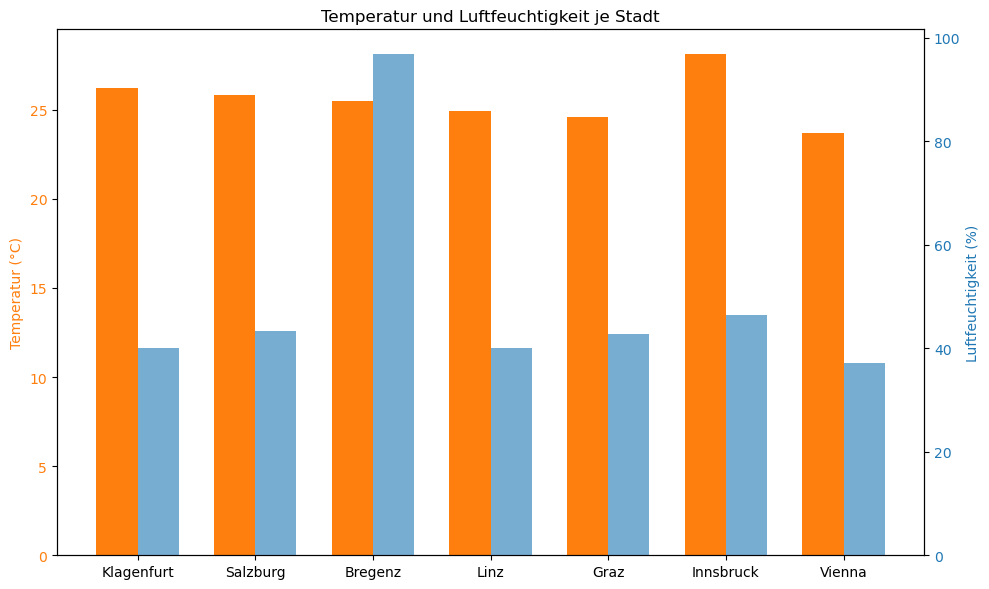

In [22]:
# Visualisierung

cities = list(avg_values.keys())
temps = [temperatures_norm.get(city, np.nan) for city in cities]
humidities = [float(avg_values[city]['avg_humidity']) for city in cities]
pressures = [avg_values[city]['avg_pressure'] for city in cities]

# Balkendiagramm: Temperatur & Luftfeuchtigkeit nebeneinander
x = np.arange(len(cities))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

bars1 = ax1.bar(x - width/2, temps, width, label='Temperatur (°C)', color='tab:orange')
ax1.set_ylabel('Temperatur (°C)', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_xticks(x)
ax1.set_xticklabels(cities)
ax1.set_title('Temperatur und Luftfeuchtigkeit je Stadt')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, humidities, width, label='Luftfeuchtigkeit (%)', color='tab:blue', alpha=0.6)
ax2.set_ylabel('Luftfeuchtigkeit (%)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

Wir vergleichen Temperatur und Luftdruck, da sich warme Luft ausdehnt, leichter wird und aufsteigt, wodurch der Luftdruck am Boden sinkt. Kalte Luft ist dichter, schwerer und sinkt ab, was zu einem höheren Luftdruck am Boden führt. Unsere Daten können diese Zusammenhänge jedoch nur teilweise bestätigen.

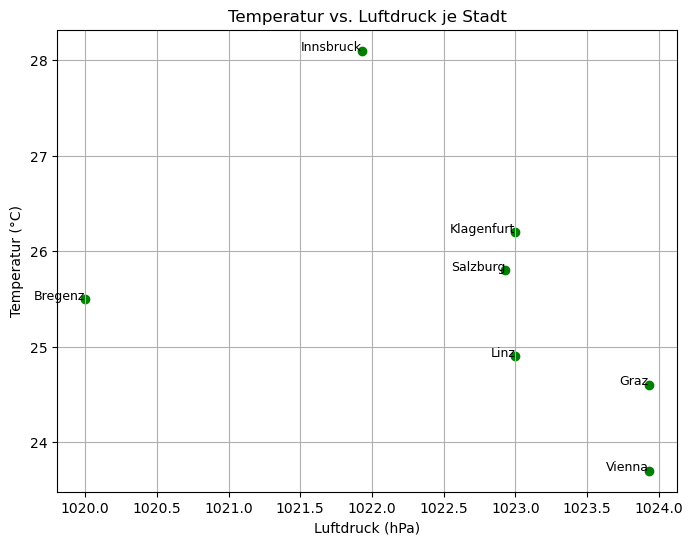

In [23]:
# Scatterplot: Temperatur vs. Luftdruck

plt.figure(figsize=(8,6))
plt.scatter(pressures, temps, color='green')

for i, city in enumerate(cities):
    plt.text(pressures[i], temps[i], city, fontsize=9, ha='right')

plt.xlabel('Luftdruck (hPa)')
plt.ylabel('Temperatur (°C)')
plt.title('Temperatur vs. Luftdruck je Stadt')
plt.grid(True)
plt.show()